In [1]:
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.style.use('science')
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# always import gbm_algos first !
import xgboost, lightgbm, catboost
from gplearn.genetic import SymbolicRegressor

# To access the contents of the parent dir
import sys; sys.path.insert(0, '../')
import os
from scipy.io import loadmat
from utils import *
from preprocess import *
from models import RobustPCANN

# Let's do facy optimizers
from optimizers import Lookahead, AdamGC, SGDGC
from madgrad import MADGRAD
from lbfgsnew import LBFGSNew

from pytorch_robust_pca import *

# Modify at /usr/local/lib/python3.9/site-packages/torch_lr_finder/lr_finder.py
from torch_lr_finder import LRFinder

# Tracking
from tqdm import trange

import sympy
import sympytorch

# Sparse regression
from pde_diff import *
from sklearn.linear_model import Lasso

Running Python 3.9.8
You can use npar for np.array


In [2]:
data = pickle_load('../deephpms_data/KdV_simple2.pkl')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['u'])

X_sol, T_sol = np.meshgrid(x, t)

x_star = X_sol.flatten()[:,None]
t_star = T_sol.flatten()[:,None]

X_star = np.hstack((x_star, t_star))
if Exact.shape[1]==X_sol.shape[0] and Exact.shape[0]==X_sol.shape[1]:
    Exact = Exact.T
u_star = Exact.flatten()[:,None]

# Bound
ub = X_star.max(axis=0)
lb = X_star.min(axis=0)

# For identification
N = 20000
# idx = np.arange(N)
idx = np.random.choice(X_star.shape[0], N, replace=False)
X_train = X_star[idx,:]
u_train = u_star[idx,:]
print("Training with", N, "samples")

noise_intensity = 0.01
noisy_xt, noisy_labels = False, False
if noisy_xt: X_train = perturb(X_train, noise_intensity); print("Noisy (x, t)")
else: print("Clean (x, t)")
if noisy_labels: u_train = perturb(u_train, noise_intensity); print("Noisy labels")
else: print("Clean labels")

# Unsup data
include_N_res = False
if include_N_res:
    N_res = N
    idx_res = np.array(range(X_star.shape[0]-1))[~idx]
    idx_res = np.random.choice(idx_res.shape[0], N_res, replace=True)
    X_res = X_star[idx_res, :]
    print(f"Training with {N_res} unsup samples")
    X_u_train = np.vstack([X_train, X_res])
    u_train = np.vstack([u_train, torch.rand(X_res.shape[0], 1) - 1000])
    # del X_res
else: print("Not including N_res")

# Convert to torch.tensor
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)

# lb and ub are used in adversarial training
scaling_factor = 1.0
lb = scaling_factor*to_tensor(lb, False)
ub = scaling_factor*to_tensor(ub, False)

# Feature names
feature_names=('uf', 'u_x', 'u_xx', 'u_xxx')

Loaded from ../deephpms_data/KdV_simple2.pkl
Training with 20000 samples
Clean (x, t)
Clean labels
Not including N_res


In [3]:
terms = ["uf*u_x", "u_xxx"]
values = [-5.850271, -0.936853]

class PDEExpression(nn.Module):
    def __init__(self, terms, values):
        super(PDEExpression, self).__init__()
        self.terms = terms
        self.values = [float(e) for e in values]
        self.diff_dict = dict(zip(self.terms, self.values))
        self.string_expression = '+'.join([str(v)+'*'+str(k) for k, v in self.diff_dict.items()])
        pde_expr, self.variables = build_exp(self.string_expression)
        print("Constructing", pde_expr, self.variables)
        self.pde_expr = sympytorch.SymPyModule(expressions=[pde_expr])
            
    # Computing the approx u_t
    def forward(self, e): return self.pde_expr(e)
    # Get a coeff
    def get_coeff(self, t): return self.diff_dict[t]

mod = PDEExpression(terms, values)

Constructing -5.850271*u_x*uf - 0.936853*u_xxx {uf, u_x, u_xxx}


In [4]:
class RobustPINN(nn.Module):
    def __init__(self, model, loss_fn, index2features, scale=False, lb=None, ub=None, pretrained=False, noiseless_mode=True, init_cs=(0.5, 0.5), init_betas=(0.0, 0.0)):
        super(RobustPINN, self).__init__()
        self.model = model
        if not pretrained: self.model.apply(self.xavier_init)
        
        self.noiseless_mode = noiseless_mode
        if self.noiseless_mode: print("No denoising")
        else: print("With denoising method")
        
        self.in_fft_nn = None; self.out_fft_nn = None
        self.inp_rpca = None; self.out_rpca = None
        if not self.noiseless_mode:
            # FFTNN
            self.in_fft_nn = FFTTh(c=init_cs[0])
            self.out_fft_nn = FFTTh(c=init_cs[1])

            # Robust Beta-PCA
            self.inp_rpca = RobustPCANN(beta=init_betas[0], is_beta_trainable=True, inp_dims=2, hidden_dims=32)
            self.out_rpca = RobustPCANN(beta=init_betas[1], is_beta_trainable=True, inp_dims=1, hidden_dims=32)
        
        self.callable_loss_fn = loss_fn
        self.param0 = nn.Parameter(torch.FloatTensor([loss_fn.get_coeff("uf*u_x")]))
        self.param1 = nn.Parameter(torch.FloatTensor([loss_fn.get_coeff("u_xxx")]))
        del self.callable_loss_fn
        
        self.index2features = index2features; self.feature2index = {}
        for idx, fn in enumerate(self.index2features): self.feature2index[fn] = str(idx)
        self.scale = scale; self.lb, self.ub = lb, ub
        self.diff_flag = diff_flag(self.index2features)
        
    def xavier_init(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward(self, x, t):
        H = torch.cat([x, t], dim=1)
        if self.scale: H = self.neural_net_scale(H)
        return self.model(H)
    
    def loss(self, X_input, X_input_noise, y_input, y_input_noise, update_network_params=True, update_pde_params=True):
        # Denoising process
        if not self.noiseless_mode:
            # (1) Denoising FFT on (x, t)
            # This line returns the approx. recon.
            X_input_noise = cat(torch.fft.ifft(self.in_fft_nn(X_input_noise[1])*X_input_noise[0]).real.reshape(-1, 1), 
                                torch.fft.ifft(self.in_fft_nn(X_input_noise[3])*X_input_noise[2]).real.reshape(-1, 1))
            X_input_noise = X_input-X_input_noise
            X_input = self.inp_rpca(X_input, X_input_noise, normalize=True)
            
            # (2) Denoising FFT on y_input
            y_input_noise = y_input-torch.fft.ifft(self.out_fft_nn(y_input_noise[1])*y_input_noise[0]).real.reshape(-1, 1)
            y_input = self.out_rpca(y_input, y_input_noise, normalize=True)
        
        grads_dict, u_t = self.grads_dict(X_input[:, 0:1], X_input[:, 1:2])
        
        total_loss = []
        # MSE Loss
        if update_network_params:
            mse_loss = F.mse_loss(grads_dict["uf"], y_input)
            total_loss.append(mse_loss)
            
        # PDE Loss
        if update_pde_params:
            u_t_pred = (self.param0*grads_dict["uf"]*grads_dict["u_x"])+(self.param1*grads_dict["u_xxx"])
            l_eq = F.mse_loss(u_t_pred, u_t)
            total_loss.append(l_eq)
            
        return total_loss
    
    def grads_dict(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        u_x = self.gradients(uf, x)[0]
        u_xx = self.gradients(u_x, x)[0]
        u_xxx = self.gradients(u_xx, x)[0]
        return {"uf":uf, "u_x":u_x, "u_xxx":u_xxx}, u_t
    
    def get_selector_data(self, x, t):
        uf = self.forward(x, t)
        u_t = self.gradients(uf, t)[0]
        
        ### PDE Loss calculation ###
        u_x = self.gradients(uf, x)[0]
        u_xx = self.gradients(u_x, x)[0]
        u_xxx = self.gradients(u_xx, x)[0]
        u_xxxx = self.gradients(u_xxx, x)[0]
        derivatives = []
        derivatives.append(uf)
        derivatives.append(u_x)
        derivatives.append(u_xx)
        derivatives.append(u_xxx)
        derivatives.append(u_xxxx)
        
        return torch.cat(derivatives, dim=1), u_t
    
    def gradients(self, func, x):
        return grad(func, x, create_graph=True, retain_graph=True, grad_outputs=torch.ones(func.shape))
    
    def neural_net_scale(self, inp): 
        return -1.0+2.0*(inp-self.lb)/(self.ub-self.lb)

In [5]:
noiseless_mode = False
model = TorchMLP(dimensions=[2, 50, 50, 50 ,50, 50, 1], activation_function=nn.Tanh, bn=nn.LayerNorm, dropout=None)

# Pretrained model
semisup_model_state_dict = cpu_load("./saved_path_inverse_small_KdV/noisy2_simple2_semisup_model_state_dict_500labeledsamples500unlabeledsamples_tanhV2.pth")
parameters = OrderedDict()
# Filter only the parts that I care about renaming (to be similar to what defined in TorchMLP).
inner_part = "network.model."
for p in semisup_model_state_dict:
    if inner_part in p:
        parameters[p.replace(inner_part, "")] = semisup_model_state_dict[p]
model.load_state_dict(parameters)

pinn = RobustPINN(model=model, loss_fn=mod, 
                  index2features=feature_names, scale=True, lb=lb, ub=ub, 
                  pretrained=True, noiseless_mode=noiseless_mode)
pinn = load_weights(pinn, "./new_saved_path/clean_all_dft_pinn.pth")

# # assigning the prefered loss_fn
# model = pinn.model
# pinn = RobustPINN(model=model, loss_fn=mod, 
#                   index2features=feature_names, scale=True, lb=lb, ub=ub, 
#                   pretrained=True, noiseless_mode=noiseless_mode)

Using old implementation of TorchMLP. See models.py for more new model-related source code.
With denoising method
Loaded the model's weights properly


In [6]:
NUMBER = 64128
NUMBER = min(NUMBER, X_star.shape[0])
xx, tt = X_star[:NUMBER, 0:1], X_star[:NUMBER, 1:2]
# xx, tt = torch.FloatTensor(xx).requires_grad_(True), torch.FloatTensor(tt).requires_grad_(True)

uf = pinn(xx, tt)
u_t = pinn.gradients(uf, tt)[0]
u_x = pinn.gradients(uf, xx)[0]
u_xx = pinn.gradients(u_x, xx)[0]
u_xxx = pinn.gradients(u_xx, xx)[0]

derivatives = []
derivatives.append(uf)
derivatives.append(u_x)
derivatives.append(u_xx)
derivatives.append(u_xxx)
derivatives = torch.cat(derivatives, dim=1)

derivatives = derivatives.detach().numpy()
u_t = u_t.detach().numpy()

In [7]:
feature_names = ["uf", "u_x", "u_xx", "u_xxx"]

X_input = derivatives
y_input = u_t

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_input = poly.fit_transform(X_input)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names): poly_feature_names[i] = f.replace(" ", "*")

In [8]:
w = TrainSTRidge(X_input[:, :], y_input, 5e-4, 1000, maxit=100, STR_iters=100, split=0.8, l0_penalty=None, normalize=2)
print("PDE derived using STRidge")
print_pde(w, poly_feature_names[:])

PDE derived using STRidge
u_t = (-0.994029 +0.000000i)u_xxx
    + (-5.997836 +0.000000i)uf*u_x
   


In [9]:
uf = pinn(X_star[:, 0:1], X_star[:, 1:2]).detach().numpy()
print(relative_l2_error(uf, u_star.detach().numpy()))
uf = uf.reshape(Exact.shape)

0.0072794966


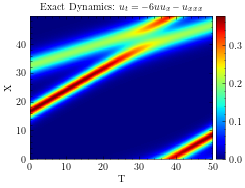

In [10]:
fig, ax = plt.subplots(1, 1)

# Artificial training points
# ax.scatter(X_u_train_np[:, 1:2], X_u_train_np[:, 0:1], 
#            marker='x', color='black')

h = ax.imshow(Exact.T, interpolation='nearest', cmap='jet', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')

ax.set_title("Exact Dynamics: $u_t = -6uu_{x}-u_{xxx}$", fontsize = 10)
ax.set_xlabel('T')
ax.set_ylabel('X')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

fig.savefig("./vis_pics/Exact_Dynamics.png", dpi=300)
plt.show()

In [11]:
pinn.param0.item(), pinn.param1.item()

(-5.990390300750732, -0.9914070963859558)

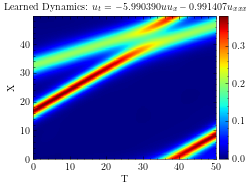

In [12]:
fig, ax = plt.subplots(1, 1)

# Artificial training points
# ax.scatter(X_u_train_np[:, 1:2], X_u_train_np[:, 0:1], 
#            marker='x', color='black')

h = ax.imshow(uf.T, interpolation='nearest', cmap='jet', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto')

ax.set_title("Learned Dynamics: $u_t = -5.990390uu_{x}-0.991407u_{xxx}$", fontsize = 10)
ax.set_xlabel('T')
ax.set_ylabel('X')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

fig.savefig("./vis_pics/Learned_Dynamics_cleanall.png", dpi=300)
plt.show()

In [9]:
_, x_fft, x_PSD = fft1d_denoise(X_train[:, 0:1], c=-5, return_real=True)
_, t_fft, t_PSD = fft1d_denoise(X_train[:, 1:2], c=-5, return_real=True)
_, u_train_fft, u_train_PSD = fft1d_denoise(u_train, c=-5, return_real=True)
x_fft, x_PSD = x_fft.detach(), x_PSD.detach()
t_fft, t_PSD = t_fft.detach(), t_PSD.detach()

In [10]:
def closure():
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    losses = pinn.loss(X_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD), update_network_params=True, update_pde_params=True)
    l = sum(losses)
    if l.requires_grad:
        l.backward(retain_graph=True)
    return l

def mtl_closure():
    losses = pinn.loss(X_train, (x_fft, x_PSD, t_fft, t_PSD), u_train, (u_train_fft, u_train_PSD), update_network_params=True, update_pde_params=True)
    updated_grads = []
    
    for i in range(len(losses)):
        optimizer1.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()): 
        param.grad = updated_grads[0][idx]+updated_grads[1][idx]
        
    return sum(losses)

In [11]:
epochs1, epochs2 = 30, 20
# TODO: Save best state dict and training for more epochs.
optimizer1 = MADGRAD(pinn.parameters(), lr=1e-5, momentum=0.9)
pinn.train(); best_train_loss = 1e6

print('1st Phase optimization using Adam with PCGrad gradient modification')
for i in range(epochs1):
    optimizer1.step(mtl_closure)
    if (i % 10) == 0 or i == epochs1-1:
        l = mtl_closure()
        print("Epoch {}: ".format(i), l.item())
        print(pinn.param0, pinn.param1)
        
optimizer2 = torch.optim.LBFGS(pinn.parameters(), lr=1e-1, max_iter=500, max_eval=int(500*1.25), history_size=300, line_search_fn='strong_wolfe')
print('2nd Phase optimization using LBFGS')
for i in range(epochs2):
    optimizer2.step(closure)
    if (i % 5) == 0 or i == epochs2-1:
        l = closure()
        print("Epoch {}: ".format(i), l.item())

1st Phase optimization using Adam with PCGrad gradient modification
Epoch 0:  5.063912976766005e-05
Parameter containing:
tensor([-5.8503], requires_grad=True) Parameter containing:
tensor([-0.9369], requires_grad=True)
Epoch 10:  4.9122034397441894e-05
Parameter containing:
tensor([-5.8502], requires_grad=True) Parameter containing:
tensor([-0.9369], requires_grad=True)
Epoch 20:  4.8117755795829e-05
Parameter containing:
tensor([-5.8502], requires_grad=True) Parameter containing:
tensor([-0.9369], requires_grad=True)
Epoch 29:  4.7606990847270936e-05
Parameter containing:
tensor([-5.8502], requires_grad=True) Parameter containing:
tensor([-0.9370], requires_grad=True)
2nd Phase optimization using LBFGS
Epoch 0:  4.051686846651137e-05
Epoch 5:  4.051684300065972e-05
Epoch 10:  4.051684300065972e-05
Epoch 15:  4.051684300065972e-05
Epoch 19:  4.051684300065972e-05


In [12]:
errs = 100*np.abs(npar([(pinn.param0.item()+6)/6.0, pinn.param1.item()+1]))
errs.mean(), errs.std()

(3.5126914580663047, 1.2020895878473916)

In [13]:
pinn.param0, pinn.param1

(Parameter containing:
 tensor([-5.8614], requires_grad=True),
 Parameter containing:
 tensor([-0.9529], requires_grad=True))

In [14]:
save(pinn, "./new_saved_path/noisy2_dft_pinn.pth")

In [16]:
# w/o DFT
# clean all
# u_t = (-0.994025 +0.000000i)u_xxx
#     + (-5.995811 +0.000000i)uf*u_x
# [0.33500000000000013, 0.26500000000000046]
# Clean (x, t) but noisy labels
# u_t = (-0.9905 +0.000000i)u_xxx
#     + (-6.0031 +0.000000i)uf*u_x
# (0.5000293254852295, 0.4481017589569092)
# Noisy (x, t) and noisy labels
# u_t = (-0.9530 +0.000000i)u_xxx
#     + (-5.8598 +0.000000i)uf*u_x
# (3.5194198290506997, 1.182838280995687)

# w/ DFT
# clean all | relative l2 = 0.0072794966
# u_t = (-0.990969 +0.000000i)u_xxx
#     + (-5.990427 +0.000000i)uf*u_x
# (0.5313247442245483, 0.3717750310897827)                                                                                                                                                                                                                                                                                                                                                                                                
# Clean (x, t) but noisy labels | relative l2 = 0.008620143
# u_t = (-0.9938 +0.000000i)u_xxx
#     + (-6.0020 +0.000000i)uf*u_x
# (0.32562116781870526, 0.2929975589116415)
# Noisy (x, t) and noisy labels | relative l2 = 0.008727832
# u_t = (-0.9531 +0.000000i)u_xxx
#     + (-5.8614 +0.000000i)uf*u_x
# (3.5126914580663047, 1.2020895878473916)